### Chargement des données
Dans cette section, nous allons charger les données à partir d'un fichier Excel. Nous utiliserons la bibliothèque `ExcelReaders` pour lire le fichier et la bibliothèque `DataFrames` pour manipuler les données.


In [ ]:
using DataFrames
using ExcelReaders
using Plots
using DataValues
using XLSX
using Statistics
using Tables

### Avant de commencer à éxécuter les cellules du code
- Copier dans la variable `chemin_données`, le chemin d'accès vers le dossier `Données_EDF_240611`
- Copier dans la variable `chemin_projet`, le chemin d'accès vers le dossier `JuliaStatsProject`

Dans cette section, nous chargeons les données à partir des fichier Excel `IND-COL-1.xls` et `IND-COL-2.xls` situé dans le répertoire spécifié.

In [ ]:
chemin_données = "/home/AD/faidy/JuliaStatsProject/data/real_data/"
chemin_projet = "/home/AD/faidy/JuliaStatsProject/"

In [ ]:
data_matrix_ind_col1 = readxlsheet(string(chemin_données, "Données_EDF_240611/Colmatage/IND-COL-1.xls"), "IND-COL-1")

In [ ]:
data_matrix_ind_col2 = readxlsheet(string(chemin_données, "Données_EDF_240611/Colmatage/IND-COL-2.xls"), "IND-COL-2")

In [ ]:
typeof(data_matrix_ind_col1)

In [ ]:
isNA(x) = typeof(x) == DataValue{Union{}}
valeurs = replace( x -> isNA(x) ? missing : x, data_matrix_ind_col1)

data_matrix_ind_col1 = replace( x -> isNA(x) ? missing : x, data_matrix_ind_col1)
data_matrix_ind_col2 = replace( x -> isNA(x) ? missing : x, data_matrix_ind_col2)

### Conversion de Matrice en DataFrame

La fonction `MatrixToDataFrame(mat)` prend en entrée une matrice `mat` et retourne un DataFrame `DF_mat` en excluant la première ligne de `mat` comme les noms de colonnes.

#### Paramètres :

- `mat` : Une matrice représentant les données à convertir en DataFrame.

#### Sortie :

Un objet DataFrame `DF_mat` où les données de la première ligne de `mat` sont utilisées comme noms de colonnes.

Cette fonction est utile pour convertir des données structurées sous forme de matrice en un format plus facile à manipuler et à analyser à l'aide de la bibliothèque `DataFrames` en Julia.


In [ ]:
function MatrixToDataFrame(mat)
    DF_mat = DataFrame(
        mat[2:end, 1:end],
        string.(mat[1, 1:end])
    )
    return DF_mat
end

In [ ]:
df1 = MatrixToDataFrame(data_matrix_ind_col1)


In [ ]:
df2 = MatrixToDataFrame(data_matrix_ind_col2)

In [ ]:
typeof(df1)

### Suppression des valeurs manquantes

Les lignes suivantes suppriment les lignes de `df1` et `df2` où la colonne `:VALEUR` contient des valeurs manquantes.


In [ ]:
df1 = dropmissing(df1, :VALEUR)

In [ ]:
df2 = dropmissing(df2, :VALEUR)

### Fusion de deux DataFrames

La ligne suivante fusionne les DataFrames `df1` et `df2` en un seul DataFrame `df_one_two`, en ajoutant les colonnes de manière à inclure toutes les colonnes présentes dans les deux DataFrames.

In [ ]:
df_one_two = vcat(df1, df2, cols = :union )

### Chargement et prétraitement des données de nettoyages

Les lignes suivantes chargent les données à partir du fichier Excel "NETTOYAGES.xls" et effectuent plusieurs étapes de prétraitement pour obtenir un DataFrame `df_nettoyages` bien structuré.

In [ ]:
nettoyages = readxlsheet(string(chemin_données, "Données_EDF_240611/Nettoyages/NETTOYAGES.xls"), "NETTOYAGES")
df_nettoyages = MatrixToDataFrame(nettoyages)
# df_nettoyages = df_nettoyages[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :HEURES_MAT]]
df_nettoyages = rename!(df_nettoyages, :HEURES_MAT => :HEURES_NETT)

In [ ]:
df_RGV = readxlsheet(string(chemin_données, "Données_EDF_240611/RGV/RGV.xls"), "RGV")
df_RGV = MatrixToDataFrame(df_RGV)

### Prétraitement des DataFrames pour gérer la permutation

La fonction suivante, `preprocess_data!`, prend en entrée un DataFrame `df` et effectue un traitement spécifique pour gérer les permutations de lignes selon certaines conditions.


In [ ]:
# Preprocess data frames to handle the permutation
function preprocess_data!(df)
    i = 1
    while i < nrow(df)
        if df.APRES_NET[i] == 1 && df.AVANT_NET[i + 1] == 1
            # Permute the rows
            df[i, :], df[i + 1, :] = df[i + 1, :], df[i, :]
            i += 1  # Skip the next row as it was just swapped
        end
        i += 1
    end
end

In [ ]:
function combine_rows_with_same_heures_mat(df::DataFrame)
    # Grouper par HEURES_MAT
    grouped = groupby(df, [:UNITE, :SOUS_UNITE, :CIRCUIT, :HEURES_MAT, :PE])
    
    # Nouveau DataFrame pour stocker les résultats
    result_df = DataFrame(UNITE=String[], SOUS_UNITE=String[], CIRCUIT=String[], NUMERO=Float64[], HEURES_MAT=Int64[], PE=String[], BR=String[], VALEUR=Float64[])
    
    for subdf in grouped
        unique_heures_mat = unique(subdf.HEURES_MAT)[1]
        unite = unique(subdf.UNITE)[1]
        sous_unite = unique(subdf.SOUS_UNITE)[1]
        circuit = unique(subdf.CIRCUIT)[1]
        pe = unique(subdf.PE)[1]
        numero = unique(subdf.NUMERO)[1]
        if nrow(subdf) == 2 && length(unique(subdf.BR)) == 2
            # Calculer la moyenne de VALEUR
            mean_valeur = mean(subdf.VALEUR)
            # Ajouter une ligne avec BR = " " et la moyenne de VALEUR
            push!(result_df, (UNITE=unite, SOUS_UNITE=sous_unite, CIRCUIT=circuit, NUMERO=numero, BR=" ", PE=pe, HEURES_MAT=unique_heures_mat, VALEUR=mean_valeur))
        else
            # Ajouter les lignes telles quelles si elles ne correspondent pas aux critères
            append!(result_df, subdf[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :BR, :PE, :HEURES_MAT, :VALEUR]])
        end
    end
    
    return result_df
end


# Appliquer la fonction
result_df = combine_rows_with_same_heures_mat(df1)
println(result_df)


### Visualisation conditionnelle des données IND-COL-1 et IND-COL-2

Le bloc de code suivant effectue une analyse et une visualisation conditionnelles des données IND-COL-1 et IND-COL-2 pour différentes unités et sous-unités, en tenant compte des temps de nettoyage.

In [ ]:
df_one_two = df_one_two[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :BR, :PE, :HEURES_MAT, :VALEUR, :AVANT_NET, :APRES_NET, :SONDE]]
unites = unique(df_one_two.UNITE)

nbE9 = 0
nbE8 = 0

for unite in unites
    unite_data = df_one_two[df_one_two.UNITE .== unite, :]
    sous_unites = unique(unite_data.SOUS_UNITE)
    
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite, :]
        
        # Initialize arrays to store combined data for all circuits within a sous_unite
        combined_ind_col_1_C = Vector{DataFrame}()
        combined_ind_col_2_C = Vector{DataFrame}()
        combined_ind_col_1_F = Vector{DataFrame}()
        combined_ind_col_2_F = Vector{DataFrame}()
        
        circuits = unique(sous_unite_data.CIRCUIT)
        
        PE = "E9"
        for circuit in circuits
            circuit_data_C = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
            circuit_data_F = filter(row -> row.PE .== "E9" && row.BR .== "F", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
            nbE9 += 1
            if isempty(circuit_data_C)
                circuit_data_C = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
                circuit_data_F = filter(row -> row.PE .== "E8" && row.BR .== "F", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
                nbE9 -= 1
                nbE8 += 1
                PE = "E8"
            end
            
            ind_col_1_C = circuit_data_C[ismissing.(circuit_data_C.SONDE), :]
            ind_col_1_F = circuit_data_F[ismissing.(circuit_data_F.SONDE), :]
            sort!(ind_col_1_C, :HEURES_MAT)
            sort!(ind_col_1_F, :HEURES_MAT)
            ind_col_2_C = circuit_data_C[.!ismissing.(circuit_data_C.SONDE), :]
            ind_col_2_F = circuit_data_F[.!ismissing.(circuit_data_F.SONDE), :]
            sort!(ind_col_2_C, :HEURES_MAT)
            sort!(ind_col_2_F, :HEURES_MAT)
            
            # Append data to the combined arrays
            push!(combined_ind_col_1_C, ind_col_1_C)
            push!(combined_ind_col_1_F, ind_col_1_F)
            push!(combined_ind_col_2_C, ind_col_2_C)
            push!(combined_ind_col_2_F, ind_col_2_F)
        end
        
        heures_nettoyages = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_nettoyages)
        
        if !isempty(heures_nettoyages)
            nettoyage_times = unique(heures_nettoyages[:, [6, 7, 8]])

            has_points_between_nettoyages_1 = true
            for i in 1:nrow(nettoyage_times) - 1
                for df in combined_ind_col_1_C
                    if !any((df.HEURES_MAT .> nettoyage_times.HEURES_NETT[i]) .& (df.HEURES_MAT .< nettoyage_times.HEURES_NETT[i + 1]))
                        has_points_between_nettoyages_1 = false
                        break
                    end
                end
            end
            
            has_points_between_nettoyages_2 = true
            for i in 1:nrow(nettoyage_times) - 1
                for df in combined_ind_col_2_C
                    if !any((df.HEURES_MAT .> nettoyage_times.HEURES_NETT[i]) .& (df.HEURES_MAT .< nettoyage_times.HEURES_NETT[i + 1]))
                        has_points_between_nettoyages_2 = false
                        break
                    end
                end
            end
            
            if has_points_between_nettoyages_1 || has_points_between_nettoyages_2
                p = plot(
                    xlabel="HEURES_MAT", 
                    ylabel="VALEUR", 
                    title="Évolution de IND-COL-1 et IND-COL-2 sur le(s) GV de $unite-$sous_unite de PE=$PE", 
                    titlefont=10
                    )
                
                # Apply preprocessing to combined_ind_col_1 and combined_ind_col_2
                for df in combined_ind_col_1_C
                    preprocess_data!(df)
                end

                for df in combined_ind_col_2_C
                    preprocess_data!(df)
                end

                for df in combined_ind_col_1_F
                    preprocess_data!(df)
                end

                for df in combined_ind_col_2_F
                    preprocess_data!(df)
                end

                for df in combined_ind_col_1_C
                    # Trace IND-COL-1 segments conditionnellement
                    for i in 1:length(df.HEURES_MAT) - 1
                        if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                            plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:yellow, linestyle=:dash)
                        end
                    end
                end

                for df in combined_ind_col_2_C
                    # Trace IND-COL-2 segments conditionnellement
                    for i in 1:length(df.HEURES_MAT) - 1
                        if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                            plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:red, linestyle=:dash)
                        end
                    end
                end
                
                a = true

                for df in combined_ind_col_1_C
                    # Trace les points
                    scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:circle, label=a ? "1-C" : false, markercolor=:yellow)
                    a = false
                end

                a = true

                for df in combined_ind_col_2_C
                    scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:diamond, label=a ? "2-C" : false, markercolor=:red)
                    a = false
                end

                
                for df in combined_ind_col_1_F
                    # Trace IND-COL-1 segments conditionnellement
                    for i in 1:length(df.HEURES_MAT) - 1
                        if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                            plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:green, linestyle=:dash)
                        end
                    end
                end
                
                for df in combined_ind_col_2_F
                    # Trace IND-COL-2 segments conditionnellement
                    for i in 1:length(df.HEURES_MAT) - 1
                        if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                        plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:blue, linestyle=:dash)
                        end
                    end
                end
                
                a = true
                for df in combined_ind_col_1_F
                    # Trace les points
                    scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:circle, label=a ? "1-F" : false, markercolor=:green)
                    a = false
                end

                a = true
                for df in combined_ind_col_2_F
                    scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:diamond, label=a ? "2-F" : false, markercolor=:blue)
                    a = false
                end
                
                # Trace des lignes verticales pour les temps de nettoyage
                nettoyage_times_0 = nettoyage_times[nettoyage_times[:, 2] .== 0, :]
                nettoyage_times_1 = nettoyage_times[nettoyage_times[:, 2] .== 1, :]

                vline!(p, nettoyage_times_0.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)
                vline!(p, nettoyage_times_1.HEURES_NETT, linestyle=:dot, color=:grey, linewidth=1.5, label=false)

                heures_RGV = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_RGV)

                vline!(p, heures_RGV.HEURES_S, linestyle=:dash, color=:purple, linewidth=1.5, label=false)
                # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
                directory = string(chemin_projet, "plots/IND-COL-1-2 filtré")
                
                # Combiner le chemin de répertoire et le nom du fichier
                filename = joinpath(directory, "IND-COL-1&2 $unite $sous_unite.png")
                
                # Sauvegarder le graphique dans le fichier spécifié
                savefig(p, filename)
            end
        end
    end
end


In [ ]:
### non filtré

df_one_two = df_one_two[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :BR, :PE, :HEURES_MAT, :VALEUR, :AVANT_NET, :APRES_NET, :SONDE]]
unites = unique(df_one_two.UNITE)

nbE9 = 0
nbE8 = 0

for unite in unites
    unite_data = df_one_two[df_one_two.UNITE .== unite, :]
    sous_unites = unique(unite_data.SOUS_UNITE)
    
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite, :]
        
        # Initialize arrays to store combined data for all circuits within a sous_unite
        combined_ind_col_1_C = Vector{DataFrame}()
        combined_ind_col_2_C = Vector{DataFrame}()
        combined_ind_col_1_F = Vector{DataFrame}()
        combined_ind_col_2_F = Vector{DataFrame}()
        
        circuits = unique(sous_unite_data.CIRCUIT)
        
        PE = "E9"
        for circuit in circuits
            nbE9 += 1
            circuit_data_C = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
            circuit_data_F = filter(row -> row.PE .== "E9" && row.BR .== "F", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
            if isempty(circuit_data_C)
                circuit_data_C = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
                circuit_data_F = filter(row -> row.PE .== "E8" && row.BR .== "F", sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :])
                nbE9 -= 1
                nbE8 += 1
                PE = "E8"
            end
            
            ind_col_1_C = circuit_data_C[ismissing.(circuit_data_C.SONDE), :]
            ind_col_1_F = circuit_data_F[ismissing.(circuit_data_F.SONDE), :]
            sort!(ind_col_1_C, :HEURES_MAT)
            sort!(ind_col_1_F, :HEURES_MAT)
            ind_col_2_C = circuit_data_C[.!ismissing.(circuit_data_C.SONDE), :]
            ind_col_2_F = circuit_data_F[.!ismissing.(circuit_data_F.SONDE), :]
            sort!(ind_col_2_C, :HEURES_MAT)
            sort!(ind_col_2_F, :HEURES_MAT)
            
            # Append data to the combined arrays
            push!(combined_ind_col_1_C, ind_col_1_C)
            push!(combined_ind_col_1_F, ind_col_1_F)
            push!(combined_ind_col_2_C, ind_col_2_C)
            push!(combined_ind_col_2_F, ind_col_2_F)
        end
        
        heures_nettoyages = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_nettoyages)
        
        nettoyage_times = unique(heures_nettoyages[:, [6, 7, 8]])

        p = plot(
            xlabel="HEURES_MAT", 
            ylabel="VALEUR", 
            title="Évolution de IND-COL-1 et IND-COL-2 sur le(s) GV de $unite-$sous_unite de PE=$PE", 
            titlefont=10
            )
        
        # Apply preprocessing to combined_ind_col_1 and combined_ind_col_2
        for df in combined_ind_col_1_C
            preprocess_data!(df)
        end

        for df in combined_ind_col_2_C
            preprocess_data!(df)
        end

        for df in combined_ind_col_1_F
            preprocess_data!(df)
        end

        for df in combined_ind_col_2_F
            preprocess_data!(df)
        end

        for df in combined_ind_col_1_C
            # Trace IND-COL-1 segments conditionnellement
            for i in 1:length(df.HEURES_MAT) - 1
                if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                    plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:yellow, linestyle=:dash)
                end
            end
        end

        for df in combined_ind_col_2_C
            # Trace IND-COL-2 segments conditionnellement
            for i in 1:length(df.HEURES_MAT) - 1
                if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                    plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:red, linestyle=:dash)
                end
            end
        end
        
        a = true

        for df in combined_ind_col_1_C
            # Trace les points
            scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:circle, label=a ? "1-C" : false, markercolor=:yellow)
            a = false
        end

        a = true

        for df in combined_ind_col_2_C
            scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:diamond, label=a ? "2-C" : false, markercolor=:red)
            a = false
        end

        
        for df in combined_ind_col_1_F
            # Trace IND-COL-1 segments conditionnellement
            for i in 1:length(df.HEURES_MAT) - 1
                if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                    plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:green, linestyle=:dash)
                end
            end
        end
        
        for df in combined_ind_col_2_F
            # Trace IND-COL-2 segments conditionnellement
            for i in 1:length(df.HEURES_MAT) - 1
                if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=:blue, linestyle=:dash)
                end
            end
        end
        
        a = true
        for df in combined_ind_col_1_F
            # Trace les points
            scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:circle, label=a ? "1-F" : false, markercolor=:green)
            a = false
        end

        a = true
        for df in combined_ind_col_2_F
            scatter!(p, df.HEURES_MAT, df.VALEUR, markershape=:diamond, label=a ? "2-F" : false, markercolor=:blue)
            a = false
        end
        
        # Trace des lignes verticales pour les temps de nettoyage
        nettoyage_times_0 = nettoyage_times[nettoyage_times[:, 2] .== 0, :]
        nettoyage_times_1 = nettoyage_times[nettoyage_times[:, 2] .== 1, :]

        vline!(p, nettoyage_times_0.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)
        vline!(p, nettoyage_times_1.HEURES_NETT, linestyle=:dot, color=:grey, linewidth=1.5, label=false)

        heures_RGV = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_RGV)

        vline!(p, heures_RGV.HEURES_S, linestyle=:dash, color=:purple, linewidth=1.5, label=false)
        # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
        directory = string(chemin_projet, "plots/IND-COL-1-2 non filtré")
        
        # Combiner le chemin de répertoire et le nom du fichier
        filename = joinpath(directory, "IND-COL-1&2 $unite $sous_unite.png")
        
        # Sauvegarder le graphique dans le fichier spécifié
        savefig(p, filename)
    end
end


In [ ]:
function filter_unite_sous_unite(df::DataFrame)
    # Group the dataframe by UNITE and SOUS_UNITE
    grouped = groupby(df, [:UNITE, :SOUS_UNITE])

    # Initialize dataframes for valid and invalid entries
    valid_df = DataFrame(UNITE=String[], SOUS_UNITE=String[])
    invalid_df = DataFrame(UNITE=String[], SOUS_UNITE=String[])

    # Iterate through each group
    for g in grouped
        unique_circuits = length(unique(g[!,:CIRCUIT]))
        unique_numero = length(unique(g[!,:NUMERO]))
        
        # Check if the number of NUMERO is equal to the number of CIRCUITS or its double
        if unique_numero == unique_circuits || unique_numero == 2 * unique_circuits
            push!(valid_df, (g.UNITE[1], g.SOUS_UNITE[1]))
        else
            push!(invalid_df, (g.UNITE[1], g.SOUS_UNITE[1]))
        end
    end

    return valid_df, invalid_df
end


valid_df, invalid_df = filter_unite_sous_unite(df_one_two)

println("Valid DataFrame:")
println(valid_df)
println("Invalid DataFrame:")
println(invalid_df)


In [ ]:
circuit_shapes = Dict{String, Symbol}()

circuit_shapes["C1"]= :circle
circuit_shapes["C2"]= :diamond
circuit_shapes["C3"]= :star5
circuit_shapes["C4"]= :rect


In [ ]:
df_one_two = df_one_two[:, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :BR, :PE, :HEURES_MAT, :VALEUR, :AVANT_NET, :APRES_NET, :SONDE]]
unites = unique(df_one_two.UNITE)

# Création du dictionnaire pour stocker les DataFrames
data_dict = Dict{Tuple{String, String, String, String, Float64, String}, DataFrame}()

for unite in unites
    unite_data = df_one_two[df_one_two.UNITE .== unite, :]
    sous_unites = unique(unite_data.SOUS_UNITE)
    
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite, :]
        
        circuits = unique(sous_unite_data.CIRCUIT)
        num_numeros_sous_unite = length(unique(sous_unite_data.NUMERO))
        num_circuits = length(circuits)
        
        heures_nettoyages = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_nettoyages)
        nettoyage_times = unique(heures_nettoyages[:, [6, 7, 8]])
        
        if num_numeros_sous_unite == num_circuits
            p = plot(
                xlabel="HEURES_MAT", 
                ylabel="VALEUR", 
                title="IND-COL-1 et IND-COL-2 de $unite-$sous_unite", 
                titlefont=10
                )

            for circuit in circuits
                circuit_data = sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :]
            
                circuit_data_C = filter(row -> row.PE .== "E9" && row.BR .== "C", circuit_data)
                circuit_data_F = filter(row -> row.PE .== "E9" && row.BR .== "F", circuit_data)
                if isempty(circuit_data_C)
                    circuit_data_C = filter(row -> row.PE .== "E8" && row.BR .== "C", circuit_data)
                    circuit_data_F = filter(row -> row.PE .== "E8" && row.BR .== "F", circuit_data)
                end
                
                ind_col_1_C = circuit_data_C[ismissing.(circuit_data_C.SONDE), :]
                ind_col_1_F = circuit_data_F[ismissing.(circuit_data_F.SONDE), :]

                sort!(ind_col_1_C, :HEURES_MAT)
                sort!(ind_col_1_F, :HEURES_MAT)

                ind_col_2_C = circuit_data_C[.!ismissing.(circuit_data_C.SONDE), :]
                ind_col_2_F = circuit_data_F[.!ismissing.(circuit_data_F.SONDE), :]

                sort!(ind_col_2_C, :HEURES_MAT)
                sort!(ind_col_2_F, :HEURES_MAT)

                num = (unique(filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite && row.CIRCUIT .== circuit,
                df_one_two[:,[:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO]])).NUMERO)[1]

                vec = [ind_col_2_C, ind_col_2_F, ind_col_1_C, ind_col_1_F]
                colors = [:red , :blue, :yellow, :green]

                for df in vec
                    preprocess_data!(df)
                end

                for (color, df) in zip(colors, vec)
                    # Trace IND-COL-1 segments conditionnellement
                    for i in 1:length(df.HEURES_MAT) - 1
                        if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] 
                            || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                            plot!(p, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=color, linestyle=:dash)
                        end
                    end
                end

                
                for (color, df) in zip(colors, vec)
                    # Trace les points
                    scatter!(p, df.HEURES_MAT, df.VALEUR, alpha=.75, label = false, markershape=circuit_shapes[circuit], markercolor=color)
                end

                # Ajout des DataFrames au dictionnaire
                data_dict[(unite, sous_unite, circuit, "C", num, "IND-COL-1")] = ind_col_1_C
                data_dict[(unite, sous_unite, circuit, "F", num, "IND-COL-1")] = ind_col_1_F
                data_dict[(unite, sous_unite, circuit, "C", num, "IND-COL-2")] = ind_col_2_C
                data_dict[(unite, sous_unite, circuit, "F", num, "IND-COL-2")] = ind_col_2_F
            end

            # Trace des lignes verticales pour les temps de nettoyage
            nettoyage_times_0 = nettoyage_times[nettoyage_times[:, 2] .== 0, :]
            nettoyage_times_1 = nettoyage_times[nettoyage_times[:, 2] .== 1, :]

            vline!(p, nettoyage_times_0.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)
            vline!(p, nettoyage_times_1.HEURES_NETT, linestyle=:dot, color=:grey, linewidth=1.5, label=false)

            heures_RGV = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_RGV)

            vline!(p, heures_RGV.HEURES_S, linestyle=:dash, color=:purple, linewidth=1.5, label=false)
            # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
            directory = string(chemin_projet, "plots/IND-COL-1-2 data_dict")
            
            # Combiner le chemin de répertoire et le nom du fichier
            filename = joinpath(directory, "IND-COL-1&2 $unite $sous_unite.png")
            
            # Sauvegarder le graphique dans le fichier spécifié
            savefig(p, filename)

        else #if num_numeros_sous_unite == 2 * num_circuits
            p_avant = plot(
                xlabel="HEURES_MAT", 
                ylabel="VALEUR", 
                titlefont=10
                )
            p_apres = plot(
                xlabel="HEURES_MAT", 
                ylabel="VALEUR", 
                titlefont=10
                )
            title_avant = "IND-COL-1 et IND-COL-2 de $unite-$sous_unite "
            title_apres = "IND-COL-1 et IND-COL-2 de $unite-$sous_unite "

            for circuit in circuits
                circuit_data = sous_unite_data[sous_unite_data.CIRCUIT .== circuit, :]

                sep_circuit_data_C = Vector{Tuple{DataFrame, Float64}}()
                sep_circuit_data_F = Vector{Tuple{DataFrame, Float64}}()

                numeros = unique(circuit_data.NUMERO)

                for num in numeros
                    num_data = circuit_data[circuit_data.NUMERO .== num, :]
                    num_data_C = filter(row -> row.PE .== "E9" && row.BR .== "C", num_data)
                    num_data_F = filter(row -> row.PE .== "E9" && row.BR .== "F", num_data)
                    if isempty(num_data_C)
                        num_data_C = filter(row -> row.PE .== "E8" && row.BR .== "C", num_data)
                        num_data_F = filter(row -> row.PE .== "E8" && row.BR .== "F", num_data)
                    end
                    push!(sep_circuit_data_C, (num_data_C, num))
                    push!(sep_circuit_data_F, (num_data_F, num))
                end
                
                # Trier les DataFrames dans sep_circuit_data_C et sep_circuit_data_F par minimum HEURES_MAT
                sorted_sep_circuit_data_C = sort(sep_circuit_data_C, by = x -> mean(x[1][:, :HEURES_MAT]))
                sorted_sep_circuit_data_F = sort(sep_circuit_data_F, by = x -> mean(x[1][:, :HEURES_MAT]))
                
                sorted_sep_circuit_data = [("C", sorted_sep_circuit_data_C), ("F", sorted_sep_circuit_data_F)]
                for (BR, sorted_sep_circuit) in sorted_sep_circuit_data
                    etat = "AVANT"
                    for (sorted_df, num) in sorted_sep_circuit
                        ind_col_1_rgv = sorted_df[ismissing.(sorted_df.SONDE), :]
                        ind_col_2_rgv = sorted_df[.!ismissing.(sorted_df.SONDE), :]
                        sort!(ind_col_1_rgv, :HEURES_MAT)
                        sort!(ind_col_2_rgv, :HEURES_MAT)

                        if etat == "AVANT" && BR == "C"
                            title_avant = string(title_avant, "$circuit-$num ")
                        elseif BR == "C"
                            title_apres = string(title_apres, "$circuit- $num ")
                        end
                        vec = [ind_col_1_rgv, ind_col_2_rgv]
                        colors_C = [:yellow, :red]
                        colors_F = [:green, :blue]

                        for df in vec
                            preprocess_data!(df)
                        end

                        for (color, df) in zip(BR == "C" ? colors_C : colors_F, vec)
                            # Trace IND-COL-1 segments conditionnellement
                            for i in 1:length(df.HEURES_MAT) - 1
                                if !(df.AVANT_NET[i] || df.APRES_NET[i + 1] 
                                    || any((nettoyage_times.HEURES_NETT .> df.HEURES_MAT[i]) .& (nettoyage_times.HEURES_NETT .< df.HEURES_MAT[i + 1])))
                                    plot!(etat == "AVANT" ? p_avant : p_apres, df.HEURES_MAT[i:i + 1], df.VALEUR[i:i + 1], label=false, color=color, linestyle=:dash)
                                end
                            end
                        end

                        
                        for (color, df) in zip(BR == "C" ? colors_C : colors_F, vec)
                            # Trace les points
                            scatter!(etat == "AVANT" ? p_avant : p_apres, df.HEURES_MAT, df.VALEUR, alpha=.75, label = false, markershape=circuit_shapes[circuit], markercolor=color)
                        end
                        # Ajout des DataFrames triés au dictionnaire
                        data_dict[(unite, sous_unite, circuit, BR, num, "IND-COL-1")] = ind_col_1_rgv
                        data_dict[(unite, sous_unite, circuit, BR, num, "IND-COL-2")] = ind_col_2_rgv
                        etat = "APRES"
                    end
                end 
            end
            # Trace des lignes verticales pour les temps de nettoyage
            nettoyage_times_0 = nettoyage_times[nettoyage_times[:, 2] .== 0, :]
            nettoyage_times_1 = nettoyage_times[nettoyage_times[:, 2] .== 1, :]
            plots = [(true, title_apres, p_apres), (false, title_avant, p_avant)]
            for (apres, title, p) in plots
                vline!(p, nettoyage_times_0.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)
                vline!(p, nettoyage_times_1.HEURES_NETT, linestyle=:dot, color=:grey, linewidth=1.5, label=false)

                title!(p, apres ? title_apres : title_avant)

                heures_RGV = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_RGV)
                if apres
                    vline!(p, heures_RGV.HEURES_S, linestyle=:dash, color=:purple, linewidth=1.5, label=false)
                end
                # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
                directory = string(chemin_projet, "plots/IND-COL-1-2 data_dict") 
                
                # Combiner le chemin de répertoire et le nom du fichier
                filename = joinpath(directory, string("IND-COL-1&2 $unite $sous_unite", apres ? " avant " : " apres ",  "RGV.png"))
                
                # Sauvegarder le graphique dans le fichier spécifié
                savefig(p, filename)
            end
        end
    end
end


In [ ]:
data_dict[("U17", "S1", "C2", "C", 1.19, "IND-COL-2")]

In [ ]:
equal_rows = df_nettoyages[df_nettoyages[:, 7] .== df_nettoyages[:, 8], :]

In [ ]:

# Ajouter colonnes pour min et max HEURES_MAT
agg_df_one_two = combine(groupby(df_one_two, [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO]), 
                         :HEURES_MAT => minimum => :min_HEURES_MAT,
                         :HEURES_MAT => maximum => :max_HEURES_MAT)

# Fusionner les DataFrames pour filtrer
joined_df = innerjoin(df_RGV, agg_df_one_two, on=[:UNITE, :SOUS_UNITE])

# Filtrer selon le critère HEURES_S entre min et max de HEURES_MAT
filtered_df = filter(row -> row.min_HEURES_MAT <= row.HEURES_S <= row.max_HEURES_MAT, joined_df)

# Garder seulement les triplets requis
result_df = unique(filtered_df[:, [:UNITE, :SOUS_UNITE, :CIRCUIT]])
println(result_df)


In [ ]:
# Sauvegarder le DataFrame résultant dans un fichier Excel
XLSX.openxlsx("points à corriger RGV.xlsx", mode="w") do xf
    sheet = xf["Sheet1"]
    
    # Écrire les noms de colonnes
    for (col_idx, col_name) in enumerate(names(result_df))
        sheet[XLSX.CellRef(1, col_idx)] = col_name
    end
    
    # Écrire les données
    row_idx = 2  # Commencer à la ligne 2 pour les données (après les noms de colonnes)
    for row in eachrow(result_df)
        for (col_idx, col_name) in enumerate(names(result_df))
            sheet[XLSX.CellRef(row_idx, col_idx)] = row[col_name]
        end
        row_idx += 1
    end
end
println("Le fichier Excel a été sauvegardé")

In [ ]:
# Identifier les changements de NUMERO
function find_changes(df)
    change_rows = DataFrame(UNITE = String[], SOUS_UNITE = String[], CIRCUIT = String[])
    grouped_df = groupby(df, [:UNITE, :SOUS_UNITE, :CIRCUIT])
    for subdf in grouped_df
        if length(unique(subdf.NUMERO)) > 1
            push!(change_rows, subdf[:, [:UNITE, :SOUS_UNITE, :CIRCUIT]][1, :])
        end
    end
    return change_rows
end

changes_df = find_changes(df_one_two)

# Exclure les couples UNITE, SOUS_UNITE présents dans df_RGV
rgv_pairs = unique(df_RGV[:, [:UNITE, :SOUS_UNITE]])
filtered_changes_df = antijoin(changes_df, rgv_pairs, on=[:UNITE, :SOUS_UNITE])

println(filtered_changes_df)


## Nombre de sous unités pour chaque unité

In [ ]:
using DataFrames

# Supposons que df_one_two est déjà chargé

# Obtenir toutes les unités uniques
unites = unique(df_one_two.UNITE)

# Initialiser un dictionnaire pour stocker le nombre de sous-unités par unité
nombre_sous_unites = Dict{String, Int}()

# Boucle sur chaque unité unique
for unite in unites
    # Filtrer les données pour l'unité spécifique
    unite_data = df_one_two[df_one_two.UNITE .== unite, :]
    
    # Obtenir toutes les sous-unités uniques pour cette unité
    sous_unites = unique(unite_data.SOUS_UNITE)
    
    # Calculer le nombre de sous-unités
    num_sous_unites = length(sous_unites)
    
    # Stocker le résultat dans le dictionnaire
    nombre_sous_unites[unite] = num_sous_unites
end


# Convertir nombre_sous_unites en DataFrame pour faciliter la visualisation
df_nb_sous_unites = DataFrame(UNITE = collect(keys(nombre_sous_unites)), Nombre_de_sous_unites = collect(values(nombre_sous_unites)))

# Trier par ordre décroissant du nombre de sous-unités
sort!(df_nb_sous_unites, :Nombre_de_sous_unites, rev=true)

# Afficher un bar plot
bar(df_nb_sous_unites.UNITE, df_nb_sous_unites.Nombre_de_sous_unites, 
    xlabel = "Unité", 
    ylabel = "Nombre de sous-unités",
    title = "Nombre de sous-unités par unité",
    legend = false,
    fmt=:png)  # Format de l'image



## Nombre de graphe avec E9 / E8

In [ ]:
println(" % E8 : ", nbE8/(nbE8 + nbE9))
println(" % E9 : ", nbE9/(nbE8 + nbE9))

### Génération du fichier points aberrants.xlsx

In [ ]:
using DataFrames
using Plots

# Supposons que df_one_two est déjà chargé

# Créer un DataFrame pour stocker les résultats
df_nombre_circuits = DataFrame(UNITE = String[], SOUS_UNITE = String[], Nombre_de_circuits = Int[])

# Group by sur (UNITE, SOUS_UNITE) et calcul du nombre de circuits uniques
for group in groupby(df_one_two, [:UNITE, :SOUS_UNITE])
    unite = group[!, :UNITE][1]
    sous_unite = group[!, :SOUS_UNITE][1]
    nombre_circuits = length(unique(group[!, :CIRCUIT]))
    push!(df_nombre_circuits, (unite, sous_unite, nombre_circuits))
    break
end

# Trier par ordre décroissant du nombre de circuits
sort!(df_nombre_circuits, :Nombre_de_circuits, rev=true)

# Affichage des résultats
println(df_nombre_circuits)

# Optionnel : Création d'un graphique à barres avec Plots.jl
p = bar(df_nombre_circuits.UNITE .* " - " .* df_nombre_circuits.SOUS_UNITE, df_nombre_circuits.Nombre_de_circuits,
        xlabel = "Unité - Sous-unité",
        ylabel = "Nombre de circuits",
        title = "Nombre de circuits par couple (unité, sous-unité)",
        legend = false,
        xrotation = 45,  # Rotation des étiquettes sur l'axe des x
        fmt=:png)  # Format de l'image

# Enregistrer l'image du plot
savefig("bar_plot_nombre_circuits.png")

println("Le bar plot a été sauvegardé sous le nom 'bar_plot_nombre_circuits.png'")


In [ ]:
#Initialize an empty list to store the counts
nb_heures_nett = []

# Store labels for plotting
labels = []

unites = unique(df_nettoyages.UNITE)

for unite in unites
    unite_data = df_nettoyages[df_nettoyages.UNITE .== unite, :]
    sous_unites = unique(unite_data.SOUS_UNITE)
    
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite, :]
        unique_hours = unique(sous_unite_data.HEURES_NETT)
        push!(nb_heures_nett, length(unique_hours))
        push!(labels, "$unite-$sous_unite")
    end
end
# Convert the counts and labels to arrays for plotting
nb_heures_nett_array = collect(nb_heures_nett)
labels_array = collect(labels)
# Define the positions for the x-ticks
positions = 1:length(labels_array)
# Create the bar plot
bar(labels_array, nb_heures_nett_array, 
    xlabel="Unite-Sous_Unite", 
    ylabel="Number of Unique HEURES_NETT", 
    title="Unique HEURES_NETT per Unite-Sous_Unite", 
    legend=false, 
    rotation=90, 
    size=(900, 400), 
    xguidefont=font(8),
    xticks=(positions, labels_array))  # Specify positions and labels
hline!([mean(nb_heures_nett_array)], color=:red, linestyle=:dash, linewidth=2, label="Mean Value")

In [ ]:
using DataFrames


# Filtrer df_one_two pour APRES_NET = 0 et AVANT_NET = 0
filtered_df_one_two = filter(row -> row.APRES_NET == 0 && row.AVANT_NET == 0  && ismissing(row.SONDE), df_one_two)

df_n = df_nettoyages
rename!(df_n, :HEURES_NETT => :HEURES_MAT)

# Effectuer la jointure
joined_df = innerjoin(filtered_df_one_two, df_n, on = [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :HEURES_MAT])

# Compter le nombre de lignes dans le résultat de la jointure
nombre_de_points = nrow(joined_df)

println("Le nombre de points est: ", nombre_de_points)
joined_df

In [ ]:
using DataFrames


# Filtrer df_one_two pour APRES_NET = 0, AVANT_NET = 0 et SONDE = "IND-COL-2"
filtered_df_one_two = filter(row -> row.APRES_NET == 0 && row.AVANT_NET == 0 && ismissing(row.SONDE), df_one_two)

# Grouper les données filtrées par les colonnes spécifiques
grouped_df = groupby(filtered_df_one_two, [:HEURES_MAT, :UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :BR])

# Sélectionner les points selon la condition PE = "E9" ou sinon PE = "E8"
selected_rows = DataFrame()

for g in grouped_df
    if any(row -> row.PE == "E9",eachrow(g))
        selected_rows = vcat(selected_rows, filter(row -> row.PE == "E9", g))
    else
        selected_rows = vcat(selected_rows, filter(row -> row.PE == "E8", g))
    end
end

# Effectuer la jointure
joined_df = innerjoin(selected_rows, df_n, on = [:UNITE, :SOUS_UNITE, :CIRCUIT, :NUMERO, :HEURES_MAT])

# # # Compter le nombre de lignes dans le résultat de la jointure
# nombre_de_points = nrow(joined_df)

# # println("Le nombre de points est: ", nombre_de_points)



In [ ]:

# Sauvegarder le DataFrame résultant dans un fichier Excel
XLSX.openxlsx("points à corriger IND-COL-1.xlsx", mode="w") do xf
    sheet = xf["Sheet1"]
    
    # Écrire les noms de colonnes
    for (col_idx, col_name) in enumerate(names(joined_df))
        sheet[XLSX.CellRef(1, col_idx)] = col_name
    end
    
    # Écrire les données
    row_idx = 2  # Commencer à la ligne 2 pour les données (après les noms de colonnes)
    for row in eachrow(joined_df)
        for (col_idx, col_name) in enumerate(names(joined_df))
            sheet[XLSX.CellRef(row_idx, col_idx)] = row[col_name]
        end
        row_idx += 1
    end
end
println("Le fichier Excel a été sauvegardé")

## Traitement des fichiers du dossier Encrassement

#### Cette fonction sert à transformer la matrice des données en un objet DataFrame

In [ ]:
function IND_COL_3_and_EncMatToDataFrame(mat)
    # Extraire les noms des colonnes
    column_names = [mat[1,1],"$(mat[2,3])_ENC", "$(mat[2,4])_ENC", "$(mat[2,5])_ENC", "$(mat[2,6])_ENC", "$(mat[2,15])_IND_COL_3", "$(mat[2,16])_IND_COL_3", "$(mat[2,17])_IND_COL_3", "$(mat[2,18])_IND_COL_3"]

    # Créer un DataFrame à partir des données extraites
    df1 = DataFrame()
    df2 = DataFrame()

    # Ajouter les données au DataFrame
    df1[!, column_names[1]] = mat[2:end,1]
    df1[!, column_names[2]] = mat[2:end,3]
    df1[!, column_names[3]] = mat[2:end,4]
    df1[!, column_names[4]] = mat[2:end,5]
    df1[!, column_names[5]] = mat[2:end,6]

    df2[!, column_names[1]] = mat[2:end,1]
    df2[!, column_names[6]] = mat[2:end,15]
    df2[!, column_names[7]] = mat[2:end,16]
    df2[!, column_names[8]] = mat[2:end,17]
    df2[!, column_names[9]] = mat[2:end,18]

    return df1, df2
end


In [ ]:
using XLSX

# Spécifiez le chemin complet de votre répertoire
directory = string(chemin_données, "Données_EDF_240611/Encrassement")

# Utilisez readdir() pour obtenir les noms des fichiers et des sous-répertoires
files = readdir(directory)

# Filtrer les fichiers pour ne garder que ceux qui ont l'extension .xlsx
xlsx_files = filter(file -> endswith(file, ".xlsx"), files)
xlsx_files = [file for file in xlsx_files if file != "~\$PERFOS_U2S4_3,48-3,47-3,49.xlsx" && file != "~\$PERFOS_U19S2_2,45-2,43-2,44.xlsx"]
# Initialiser un dictionnaire vide pour stocker les DataFrames
dict_df_enc = Dict{String, DataFrame}()
dict_df_ind_col_3 = Dict{String, DataFrame}()

# Lire les fichiers .xlsx et afficher les premières lignes
for file in xlsx_files
    try
        # Lire la première feuille du fichier .xlsx
        df_enc, df_ind_col_3 = IND_COL_3_and_EncMatToDataFrame(XLSX.readdata("$directory/$file", "Feuil1", "A1:V1000"))
        dict_df_enc[file] = dropmissing(df_enc, :HEURES_MAT)
        dict_df_enc[file] = dropmissing(dict_df_enc[file], :C1_ENC)
        dict_df_ind_col_3[file] = dropmissing(df_ind_col_3, :HEURES_MAT)
        dict_df_ind_col_3[file] = dropmissing(dict_df_ind_col_3[file], :C1_IND_COL_3)

    catch e
        display("Erreur lors de la lecture du fichier $file: $e")
    end
end


In [ ]:
println(length(dict_df_enc))
println(size(files))

In [ ]:
# Fonction pour extraire les motifs "Ux" et "Sy"
function extract_UxSy(text::String)
    # Initialiser les variables de sortie
    Ux = ""
    Sy = ""
    
    # Trouver le premier motif "Ux"
    start_idx = findfirst(isequal('U'), text)
    if start_idx !== nothing
        end_idx = start_idx + 1
        while end_idx <= length(text) && isdigit(text[end_idx])
            end_idx += 1
        end
        Ux = text[start_idx:end_idx-1]
    end
    
    # Trouver le motif "Sy" après "Ux"
    if !isempty(Ux)
        start_idx = findnext(isequal('S'), text, end_idx)
        if start_idx !== nothing
            end_idx = start_idx + 1
            while end_idx <= length(text) && isdigit(text[end_idx])
                end_idx += 1
            end
            Sy = text[start_idx:end_idx-1]
        end
    end
    
    return Ux, Sy
end

In [ ]:
sizes = []

for file in xlsx_files
    push!(sizes, size(dict_df_enc[file])[2])
end

sum(sizes) / 56

In [ ]:
dict_df_ind_col_3["IND-ENC_U4S2_1,43-1,42-1,36-1,41.xlsx"]

In [ ]:
rename!(df_nettoyages, :HEURES_MAT => :HEURES_NETT)

In [69]:
for file in xlsx_files

    p = plot(dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C1_ENC, 
    xlabel="HEURES_MAT", ylabel="VALEUR", label="C1", markershape=:circle, 
    markercolor=:blue, linestyle=:dash)
    
    plot!(p, dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C2_ENC, 
    xlabel="HEURES_MAT", ylabel="VALEUR", label="C2", markershape=:diamond, 
    markercolor=:red, linestyle=:dash)

    plot!(p, dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C3_ENC, 
    xlabel="HEURES_MAT", ylabel="VALEUR", label="C3", markershape=:star5, 
    markercolor=:purple, linestyle=:dash)
    if !ismissing(unique(dict_df_enc[file].C4_ENC)[1] )
        plot!(p, dict_df_enc[file].HEURES_MAT, dict_df_enc[file].C4_ENC, 
        xlabel="HEURES_MAT", ylabel="VALEUR", label="C4",markershape=:rect, 
        markercolor=:gray, linestyle=:dash)
    end

    unite, sous_unite = extract_UxSy(file)
    
    heures_nettoyages = filter(raw -> raw.UNITE .== unite && raw.SOUS_UNITE .== sous_unite, df_nettoyages)
    nettoyage_times = unique(heures_nettoyages[:, [6, 7, 8]])
    nettoyage_times_0 = nettoyage_times[nettoyage_times[:, 2] .== 0, :]
    nettoyage_times_1 = nettoyage_times[nettoyage_times[:, 2] .== 1, :]

    vline!(p, nettoyage_times_0.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)
    vline!(p, nettoyage_times_1.HEURES_NETT, linestyle=:dot, color=:grey, linewidth=1.5, label=false)

    heures_RGV = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_RGV)

    vline!(p, heures_RGV.HEURES_S, linestyle=:dash, color=:purple, linewidth=1.5, label=false)


    # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
    directory = string(chemin_projet, "plots/ENC")

    # Combiner le chemin de répertoire et le nom du fichier
    filename = joinpath(directory, "$file.png")

    # Sauvegarder le graphique dans le fichier spécifié
    savefig(p, filename)

end

In [70]:
for file in xlsx_files
    p = plot(dict_df_ind_col_3[file].HEURES_MAT, dict_df_ind_col_3[file].C1_IND_COL_3, 
    xlabel="HEURES_MAT", ylabel="VALEUR", label="C1",  
    markershape=:circle, markercolor=:blue, linestyle=:dash)
    plot!(p, dict_df_ind_col_3[file].HEURES_MAT, dict_df_ind_col_3[file].C2_IND_COL_3, 
    xlabel="HEURES_MAT", ylabel="VALEUR", label="C2",   
    markershape=:diamond, markercolor=:red, linestyle=:dash)
    plot!(p, dict_df_ind_col_3[file].HEURES_MAT, dict_df_ind_col_3[file].C3_IND_COL_3, 
    xlabel="HEURES_MAT", ylabel="VALEUR", label="C3", 
    markershape=:star5, markercolor=:purple, linestyle=:dash)
    if !ismissing(unique(dict_df_ind_col_3[file].C4_IND_COL_3)[1] )
        plot!(p, dict_df_ind_col_3[file].HEURES_MAT, dict_df_ind_col_3[file].C3_IND_COL_3, 
        xlabel="HEURES_MAT", ylabel="VALEUR", label="C4", 
        markershape=:rect, markercolor=:gray, linestyle=:dash)
    end
    
    unite, sous_unite = extract_UxSy(file)
    heures_nettoyages = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_nettoyages)
    nettoyage_times = unique(heures_nettoyages[:, [6, 7, 8]])
    nettoyage_times_0 = nettoyage_times[nettoyage_times[:, 2] .== 0, :]
    nettoyage_times_1 = nettoyage_times[nettoyage_times[:, 2] .== 1, :]

    vline!(p, nettoyage_times_0.HEURES_NETT, linestyle=:dot, color=:black, linewidth=1.5, label=false)
    vline!(p, nettoyage_times_1.HEURES_NETT, linestyle=:dot, color=:grey, linewidth=1.5, label=false)

    heures_RGV = filter(row -> row.UNITE .== unite && row.SOUS_UNITE .== sous_unite, df_RGV)

    vline!(p, heures_RGV.HEURES_S, linestyle=:dash, color=:purple, linewidth=1.5, label=false)


    # Chemin du répertoire où vous souhaitez enregistrer le fichier (relatif au répertoire de travail actuel)
    directory = string(chemin_projet, "plots/IND_COL_3")

    # Combiner le chemin de répertoire et le nom du fichier
    filename = joinpath(directory, "$file.png")

    # Sauvegarder le graphique dans le fichier spécifié
    savefig(p, filename)
end

In [71]:
unites = unique(df_one_two.UNITE)
sizes_between_nett_col1 = []
sizes_between_nett_col2 = []
sizes_on_nett_col1 = []
sizes_on_nett_col2 = []
for unite in unites
    unite_data = df_one_two[df_one_two.UNITE .== unite,:]
    sous_unites = unique(unite_data.SOUS_UNITE)
    for sous_unite in sous_unites
        sous_unite_data = unite_data[unite_data.SOUS_UNITE .== sous_unite,:]
        circuits = unique(sous_unite_data.CIRCUIT)
        for circuit in circuits
            
            heures_nettoyages = filter(raw -> raw.UNITE .== unite && raw.SOUS_UNITE .== sous_unite && raw.CIRCUIT .== circuit, df_nettoyages)
            
            if !isempty(heures_nettoyages)
                circuit_data = filter(row -> row.PE .== "E9" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
                sort!(heures_nettoyages, :HEURES_NETT)

                if !isempty(circuit_data)
                    ind_col_1 = circuit_data[ismissing.(circuit_data.SONDE),:]
                    ind_col_2 = circuit_data[.!ismissing.(circuit_data.SONDE),:]
                    if !isempty(ind_col_1)    
                        # Compter les points de `circuit_data` dont `HEURES_MAT` est dans l'intervalle [start_time, end_time)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points1 = count(row -> start_time < row < end_time, ind_col_1.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_1.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col1, count_points1)
                            push!(sizes_on_nett_col1, count_points3)
                        end
                    end
                    if !isempty(ind_col_2)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points2 = count(row -> start_time < row < end_time, ind_col_2.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_2.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col2, count_points2)
                            push!(sizes_on_nett_col2, count_points3)
                        end
                    end
                else
                    circuit_data = filter(row -> row.PE .== "E8" && row.BR .== "C", sous_unite_data[sous_unite_data.CIRCUIT .== circuit,:])
                    ind_col_1 = circuit_data[ismissing.(circuit_data.SONDE),:]
                    ind_col_2 = circuit_data[.!ismissing.(circuit_data.SONDE),:]
                    
                    if !isempty(ind_col_1)    
                        # Compter les points de `circuit_data` dont `HEURES_MAT` est dans l'intervalle [start_time, end_time)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points1 = count(row -> start_time < row < end_time, ind_col_1.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_1.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col1, count_points1)
                            push!(sizes_on_nett_col1, count_points3)
                        end
                    end
                    if !isempty(ind_col_2)
                        for i in 1:(nrow(heures_nettoyages) - 1)
                            start_time = heures_nettoyages.HEURES_NETT[i]
                            end_time = heures_nettoyages.HEURES_NETT[i + 1]
                            
                            count_points2 = count(row -> start_time < row < end_time, ind_col_2.HEURES_MAT)
                            count_points3 = count(row -> start_time == row , ind_col_2.HEURES_MAT)
                            # Ajouter le nombre de points à `points_counts`
                            push!(sizes_between_nett_col2, count_points2)
                            push!(sizes_on_nett_col2, count_points3)
                        end
                    end
                end
            end
        end
    end
end



In [72]:
heures_nettoyages = filter(raw -> raw.UNITE .== "U4" && raw.SOUS_UNITE .== "S2" && raw.CIRCUIT .== "C3", df_nettoyages)


Row,UNITE,SOUS_UNITE,CIRCUIT,REFERENCE,NUMERO,HEURES_NETT,Plaque à tube - curatif,Plaque à tube - préventif,PE_CURATIF,PE_PREVENTIF,INTERVENANT,ZONE,PROCEDE,BOUE_KG,CUIVRE_KG,EFFICACITE_DECOLMATAGE_ESTIMEE_MIN,EFFICACITE_DECOLMATAGE_ESTIMEE_MAX,ACIERISTE,TUBISTE,CONSTITUTION,INTERET ANALYSE,FAMILLE PROCEDE
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,U4,S2,C3,R12,1.36,170618.0,false,true,false,true,I1,GV Entier,PROC2,1000.0,25.0,#NA,#NA,I,V,CONST2,OK NPGV,FAM2
2,U4,S2,C3,R12,1.36,212455.0,false,true,false,true,I1,GV Entier,PROC4,1014.0,13.0,5.0,6.0,I,V,CONST2,OK NPGV,FAM2


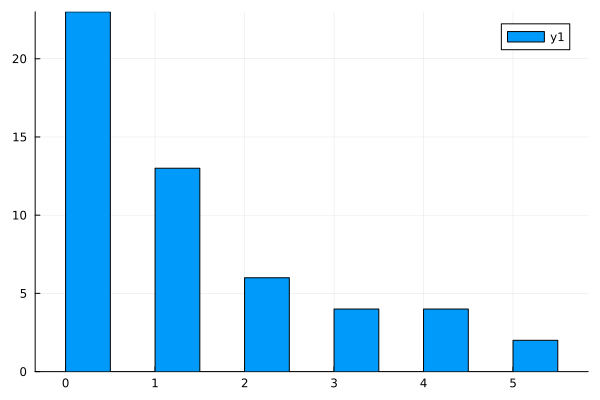

In [73]:
histogram(sizes_between_nett_col1, bins=10)

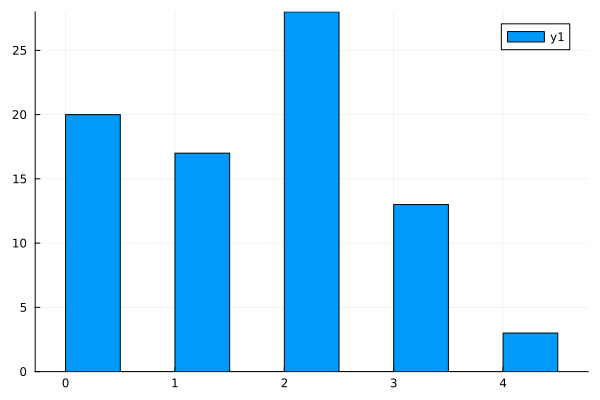

In [74]:
histogram(sizes_between_nett_col2)

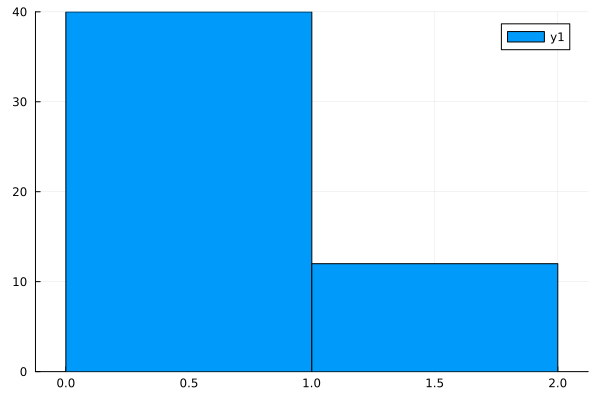

In [75]:
histogram(sizes_on_nett_col1, bins=1)

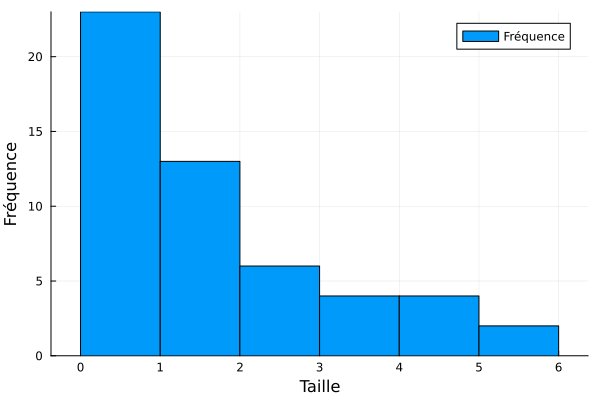

In [76]:
histogram(sizes_between_nett_col1, bins=7, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)


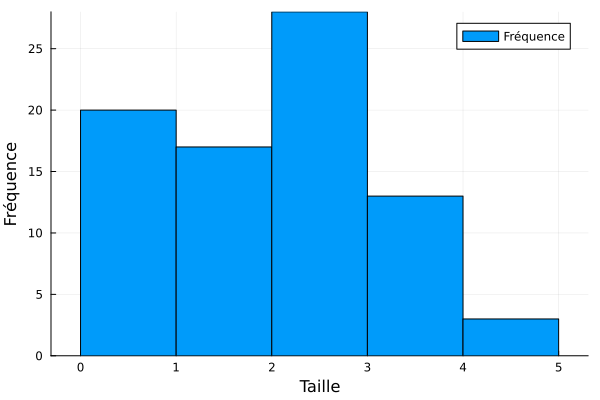

In [77]:
histogram(sizes_between_nett_col2, bins=6, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)



0.23076923076923078

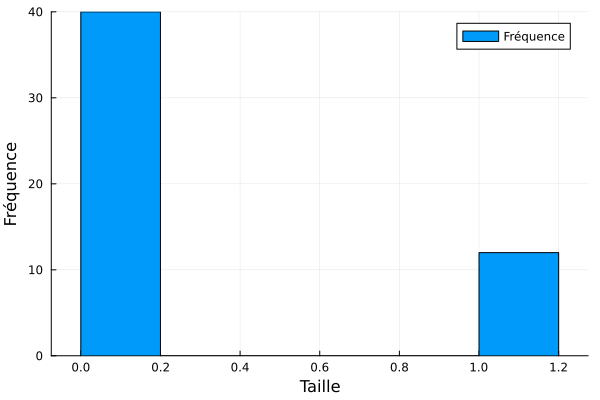

In [78]:
average_frequency = mean(sizes_on_nett_col1)
display(average_frequency)
histogram(sizes_on_nett_col1, bins=6, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)

0.6296296296296297

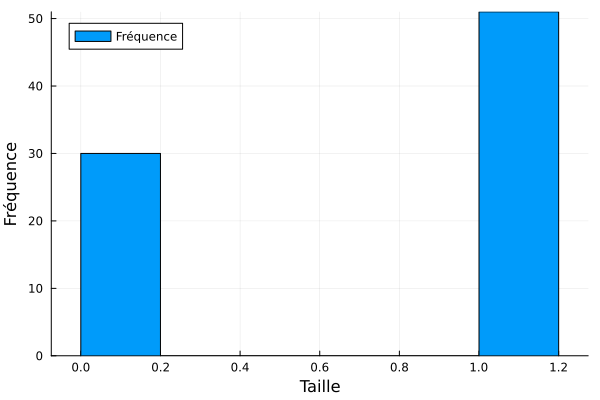

In [79]:
average_frequency = mean(sizes_on_nett_col2)
display(average_frequency)
histogram(sizes_on_nett_col2, bins=6, title="", xlabel="Taille", ylabel="Fréquence", label="Fréquence", titlefontsize=10)
